# Case Study 6 : Data Science in Any Data You Like

**Required Readings:** 
* In this case study, you could use any data as you like.
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using your Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In this case study, we explore **Instacart's** open sourced dataset which contains data related to 3 million online orders. 

Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. More about Instacart can be found over [here](https://en.wikipedia.org/wiki/Instacart). The dataset is available over [here](https://www.instacart.com/datasets/grocery-shopping-2017). 

Often, to market their products better, grocery and retail stores will perform market basket analysis, i.e. association rule mining on the past orders. This allows you to observe which items are bought together frequently, and allows a shop-owner to better organize their store. That way a customer can find bread and butter in nearby sections, allowing them to think that it would be prudent to buy them together, when it is actually the shop owners subtly nudging them in that direction. 

In case of Instacart, association rule mining will allow them to better organize their departments, and products on their website. Also allowing them to market their offers only in the relevant sections of their website. 

As [this](https://discourse.snowplowanalytics.com/t/market-basket-analysis-identifying-products-and-content-that-go-well-together/1132) article suggests, with association rule mining Instacart could:

1. Place co-occuring items in the their own category or build broader categories to accomodate all of them. 
2. Personalized recommendations based on the co-occurences can be provided to users when they add one of the items to their carts. 
3. Send out personalized emails based on past orders, recommending products.

The above reasons, among others, justify the use of association rule mining on this dataset of online orders, to find frequently ordered-together item sets.


# Data Collection/Processing: 

In [0]:
import pandas as pd
import sys
import numpy as np
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

In [0]:
orders = pd.read_csv('./orders.csv')
products = pd.read_csv('./products.csv')
orders_products_prior = pd.read_csv('./order_products__prior.csv')
orders_products_train = pd.read_csv('./order_products__train.csv')
aisles = pd.read_csv('./aisles.csv')
departments = pd.read_csv('./departments.csv')

The data dictionary to the dataset can be found [here](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b).

In [0]:
print "orders --dimensions: {0}".format(orders.shape)
print "products --dimensions: {0}".format(products.shape)
print "orders_products_prior: --dimensions: {0}".format(orders_products_prior.shape)
print "orders_products_train: --dimensions: {0}".format(orders_products_train.shape)
print "aisles: --dimensions: {0}".format(aisles.shape)
print "departments --dimensions: {0}".format(departments.shape)

orders --dimensions: (3421083, 7)
products --dimensions: (49688, 4)
orders_products_prior: --dimensions: (32434489, 4)
orders_products_train: --dimensions: (1384617, 4)
aisles: --dimensions: (134, 2)
departments --dimensions: (21, 2)


In [0]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [0]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [0]:
orders_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


We will be dropping all rows with any NA values in them, for every dataframe.

In [0]:
orders = orders.dropna()
products = products.dropna()
orders_products_prior = orders_products_prior.dropna()
aisles = aisles.dropna()
departments = departments.dropna()

# Data Exploration: Exploring the your data

** plot some properties/statistics/distribution of your data** 

Let us see how many items an average user buys per order. The distribution below is a frequency plot obtained by grouping records in `orders_products_prior` by `order_id`, and performing a count operation on it.

In [0]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

opp_groupedby_oid = orders_products_prior.groupby(['order_id'])['product_id'].count()
print "On average, users buy {0} items in a single order.".format(opp_groupedby_oid.mean())
print opp_groupedby_oid.describe()
print "Median order contains {0} items.".format(opp_groupedby_oid.median())

On average, users buy 10.0888834212 items in a single order.
count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64
Median order contains 8.0 items.


Most users will tend to buy more than one item in a single order, and that is why association rule mining is of paramount importance, to facilitate maximum gains. As can be seen in the distribution below, and the summary above, on an average a user will buy upto 10 items in a single order.

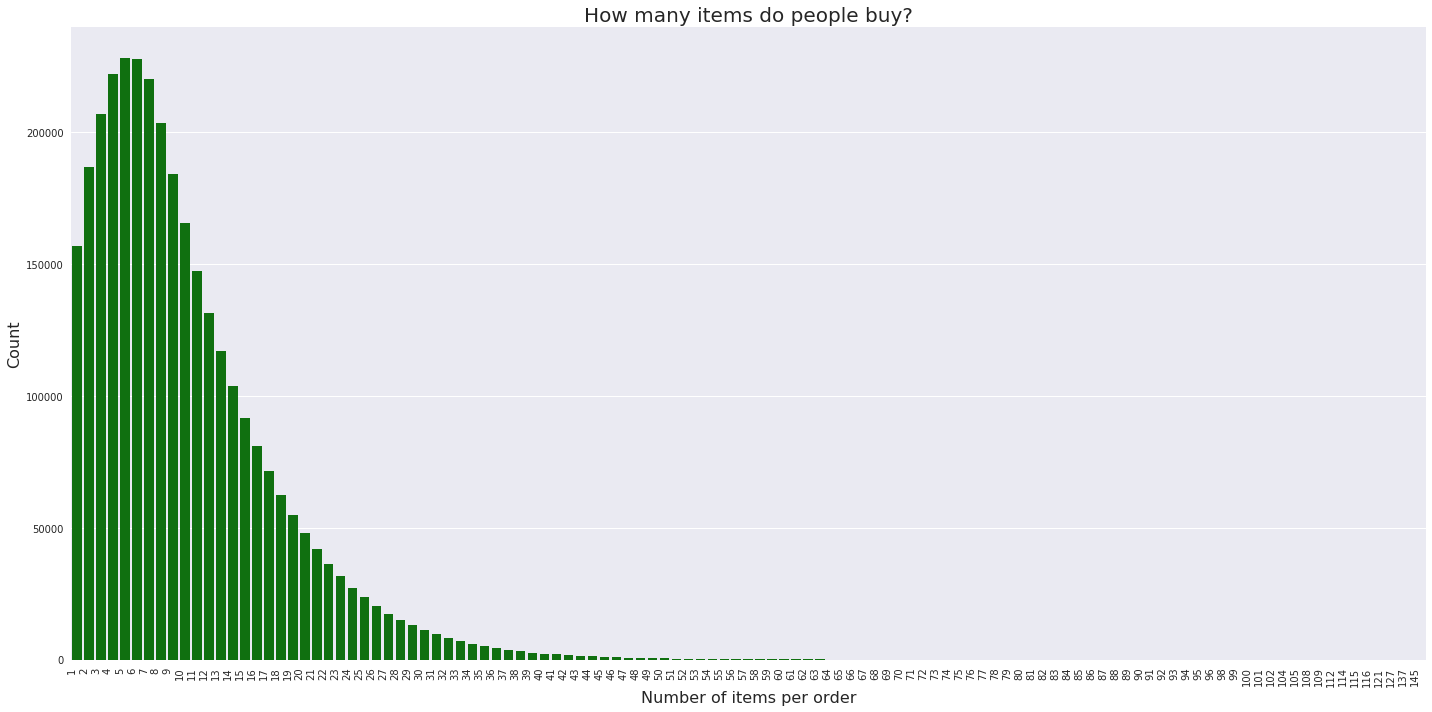

In [0]:
x = opp_groupedby_oid.values
plt.figure(figsize=(20,10))
ax = sns.countplot(x, color='green')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.xlabel('Number of items per order', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('How many items do people buy?', fontsize=20)
plt.tight_layout()

We can play around with the data a little bit more to find out the best selling items, so as to give preference to item-sets with these items when reorganizing the store/website categories.

In [0]:
opp_groupedby_pid = pd.DataFrame(orders_products_prior.groupby(['product_id'])['order_id'].count())
opp_groupedby_pid['product_id'] = opp_groupedby_pid.index
opp_groupedby_pid.rename(index=str, columns={"order_id": "counts"}, inplace=True)

In [0]:
tmp = opp_groupedby_pid.merge(products[['product_id', 'product_name']], on='product_id', how='left')[['product_name', 'counts']]
tmp.sort_values(by=['counts'], ascending=False, inplace=True)
tmp.head(20)

,product_name,counts
24848,Banana,472565
13172,Bag of Organic Bananas,379450
21133,Organic Strawberries,264683
21899,Organic Baby Spinach,241921
47198,Organic Hass Avocado,213584
47755,Organic Avocado,176815
47615,Large Lemon,152657
16793,Strawberries,142951
26204,Limes,140627
27839,Organic Whole Milk,137905


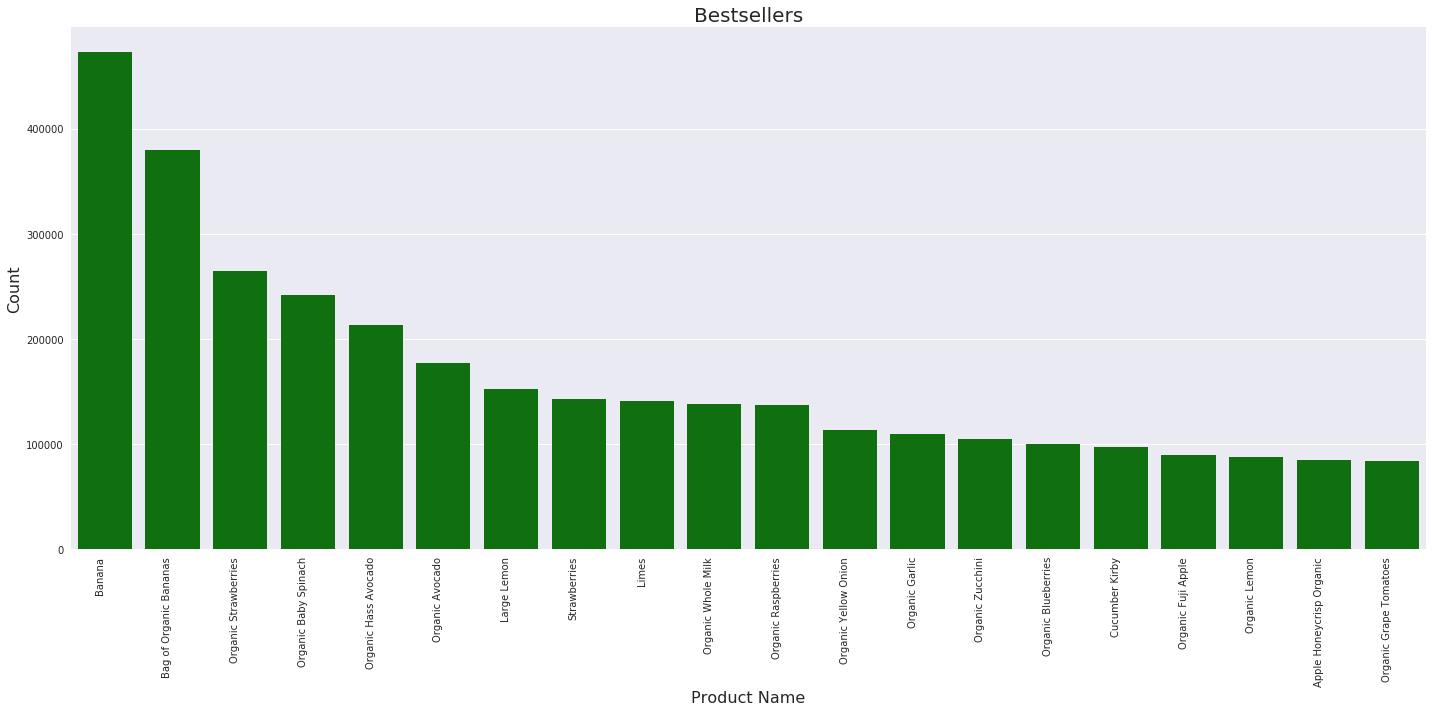

In [0]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=np.arange(1,21,1), y=tmp.head(20)['counts'].values, color='green')
ax.set_xticklabels(tmp.head(20)['product_name'].values, rotation=90, ha='right')
plt.xlabel('Product Name', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Bestsellers', fontsize=20)
plt.tight_layout()

Now we need to see the best-selling departments, which can also be taken into account along with the association rules for product placement in both stores and the website, also to assist targeted marketing.

In [0]:
opp_department = orders_products_prior[['order_id','product_id']]\
.merge(products[['product_id', 'department_id']], on='product_id', how='left')[['order_id','department_id']]\
.merge(departments, on='department_id',how='left')

In [0]:
department_counts = opp_department.groupby(['department'])['department'].count().sort_values(ascending=False)
department_counts.head()

department
produce       9479291
dairy eggs    5414016
snacks        2887550
beverages     2690129
frozen        2236432
Name: department, dtype: int64

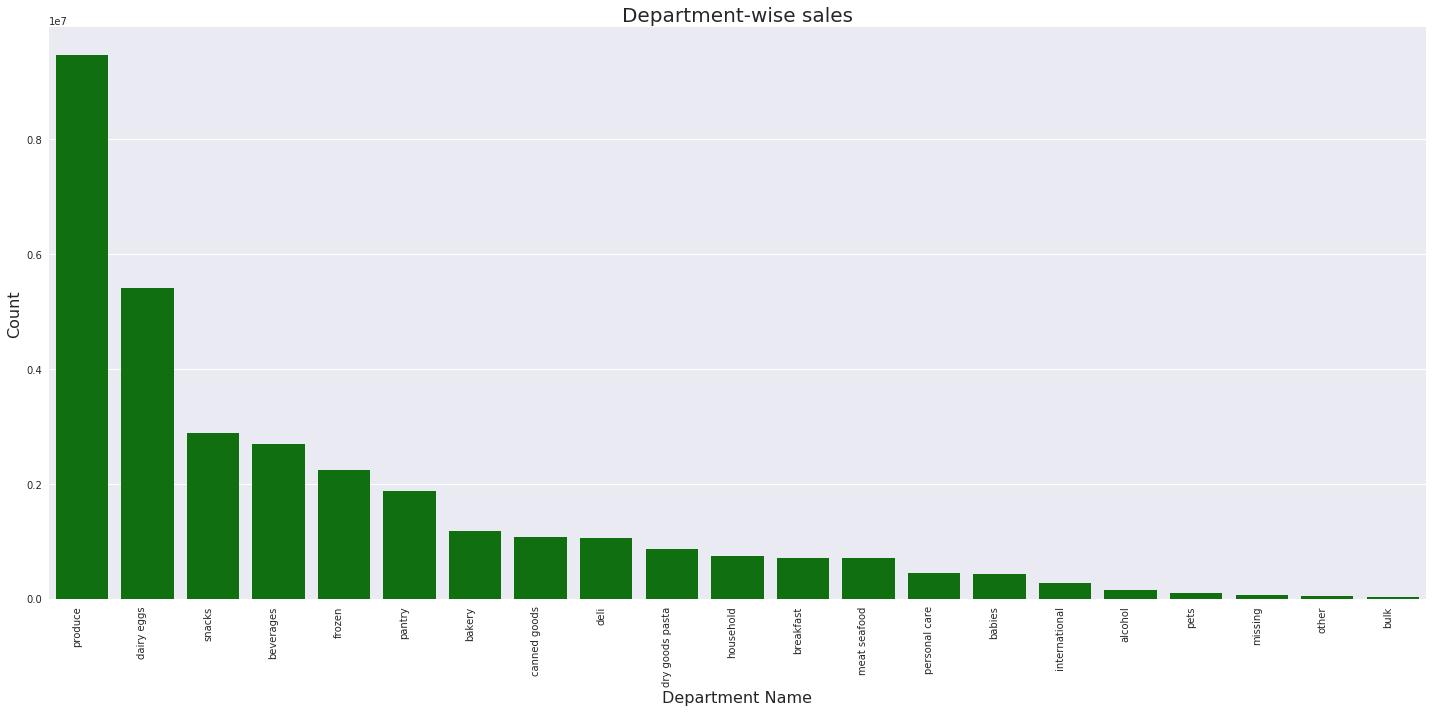

In [0]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=np.arange(1,len(department_counts) + 1,1), y=department_counts, color='green')
ax.set_xticklabels(department_counts.index, rotation=90, ha='right')
plt.xlabel('Department Name', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Department-wise sales', fontsize=20)
plt.tight_layout()

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

The apriori algorithm is often used to mine frequent itemsets and to learn association rules in a transactional database. It proceeds by identifying the frequent individual itemsets in the database and extending them to larger and larger item sets as long as those item seets appear sufficiently often in the database. In our solution, we will only focus on mining frequent-item sets of size two. Our solution is inspired by [this](https://www.kaggle.com/datatheque/association-rules-mining-market-basket-analysis) kaggle kernel.
The apriori algorithm mines the association rules in a bottom-up fashion. It first identifies individual items which pass a certain minimum metric, a metric which accounts for their frequent occurence in the transactional database. It then adds more items to each set, one item at a time, to identify 'item-sets' which will pass the minimum metric requirement. It will keep on doing this until there are no more additions to the item-sets. We then generate association rules based on these sets, and more metrics.

If we consider an association rule (A->B), where A and B are both products, we take into account the following three metrics when assessing the strength of this rule:
1. Support: Percentage of orders that contain A and B.
2. Confidence: Ratio of number of orders containing A and B to the number of orders containing A. Keep in mind that Confidence(A->B) will be different from that of Confidence(B->A).
3. Lift: This metric tells us whether there is a relationship between A and B, or whether they are occuring together by chance. Lift is a directionless metric, and is equal to Support(A,B) / (Support(A) * Support(B))

We use support and confidence thresholds to select the relevant association rules, and sort the strength by lift.

Write codes to implement the solution in python:

In [0]:
# from order_products__prior.csv import order history
orders = pd.read_csv('order_products__prior.csv')
orders = orders.set_index('order_id')['product_id'].rename('item_id')


Helper functions.

In [0]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2): # combination of 2
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]               

Association rules function.

In [0]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [0]:
# Replace item ID with item name and display association rules
rules = association_rules(orders, 0.01)  
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751



,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
11,Baby Food Pouch - Roasted Carrot Spinach & Beans,"Baby Food Pouch - Butternut Squash, Carrot & C...",332,0.011018,1503,0.049878,1290,0.042810,0.220892,0.257364,5.159830
12,Unsweetened Whole Milk Mixed Berry Greek Yogurt,Unsweetened Whole Milk Blueberry Greek Yogurt,438,0.014535,1622,0.053828,1621,0.053794,0.270037,0.270204,5.019798
23,Uncured Cracked Pepper Beef,Chipotle Beef & Pork Realstick,410,0.013606,1839,0.061029,1370,0.045465,0.222947,0.299270,4.903741
24,Organic Mango Yogurt,Organic Whole Milk Washington Black Cherry Yogurt,334,0.011084,1675,0.055586,1390,0.046128,0.199403,0.240288,4.322777
2,Grain Free Chicken Formula Cat Food,Grain Free Turkey & Salmon Formula Cat Food,391,0.012976,1809,0.060033,1553,0.051538,0.216142,0.251771,4.193848


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [0]:
# lift > 1, A and B occur together more often than random
more_often_than_random = rules_final.where(rules_final['lift'] > 1).dropna()[['itemA', 'itemB', 'lift']]
#more_often_than_random.shape # 208
more_often_than_random.head(10)

,itemA,itemB,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,5.317849
11,Baby Food Pouch - Roasted Carrot Spinach & Beans,"Baby Food Pouch - Butternut Squash, Carrot & C...",5.159830
12,Unsweetened Whole Milk Mixed Berry Greek Yogurt,Unsweetened Whole Milk Blueberry Greek Yogurt,5.019798
23,Uncured Cracked Pepper Beef,Chipotle Beef & Pork Realstick,4.903741
24,Organic Mango Yogurt,Organic Whole Milk Washington Black Cherry Yogurt,4.322777
2,Grain Free Chicken Formula Cat Food,Grain Free Turkey & Salmon Formula Cat Food,4.193848


In [0]:
# lift < 1, A and B occur together more often than random
less_often_than_random = rules_final.where(rules_final['lift'] < 1).dropna()[['itemA', 'itemB', 'lift']]
#less_often_than_random.shape # 48543
less_often_than_random.tail(10)

,itemA,itemB,lift
22572,Organic Raspberries,Raspberries,0.001249
11012,Organic Strawberries,2% Reduced Fat Milk,0.001154
246,Soda,Banana,0.001031
11555,Banana,Clementines,0.000854
1474,Strawberries,Organic Strawberries,0.000570
7271,Organic Strawberries,Strawberries,0.000516
6763,Organic Hass Avocado,Organic Avocado,0.000373
4387,Organic Avocado,Organic Hass Avocado,0.000356
2596,Banana,Bag of Organic Bananas,0.000111
670,Bag of Organic Bananas,Banana,0.000089


As can be seen with the output above, we can make use of the generated association rules for product placements, providing directed offers to customers who shop regularly in a given department, providing rudimentary recommendations. This algorithm can further be extended to obtain item-sets with more than two items, and generate corresponding association rules for each of those item sets. 

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 6".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) plot some properties/statistics/distribution of your data (10 points):
       0: missing answer
       4: okay, but with major problems
       7: good, but with minor problems
      10: perfect
    

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


